# Description
Use Approximative Baysian Computation to fit $b1$ and $\beta$ to model. Reduced $\chi^2$ was chosen as a distance function. See `Power_in_different_densities.ipynb` for elementary fitting and background discussion. In ABC would need to compute inverse covariance matrix i.e. estimate for measurement error many times (for each candidate value of b1, beta). So speed up the computation, compute the covariance matrix not based on the linear model, but on the data. See https://arxiv.org/pdf/1509.04293.pdf equation 24. This removes the b1, beta dependence and only introduces an error of an error which can be ignored in light of the desired accuracy of this analysis. 

When trying to use `Pkmus[i] = r.power['mu']` as the i-th percentile data $P(k,\mu)$ to estimate the covariance matrix, issues occur as a lot of elements are NaN (when no Fourier modes can contained in a k,mu bin to average the power over). Above alternative of using combination of multipoles weighted by Legendre polynomials works fine.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.special import legendre, spherical_jn
from scipy.integrate import simpson, quad
from scipy.linalg import pinv
import scipy.sparse as ss
from scipy.stats import bayes_mvs

import cat_power_algos as catpk
import classylss
import fitsio
import zeus
#from pymcmcstat.MCMC import MCMC 
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [8]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu') # matter power spectrum 

dk = 0.01

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8, w0_fld, wa_fld
  self.engine = ClassEngine(pars)
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


Load in density split data computed in `Power_in_different_densities.ipynb`.

In [9]:
ptile_split = np.loadtxt('density_bins/percentile_edges.txt')

ells = [0,2]
n_ptile = len(ptile_split)-1 # number of bins = number of edges - 1
Pkmus = np.empty(n_ptile, dtype='object') # contains P(k,mu) as 2D array of shape (#k, #mu) for each percentile
Pk_ells = np.empty((n_ptile, len(ells)), dtype='object') # each column contains multipole of all percentiles

for i in range(n_ptile):
    r = FFTPower.load('density_bins/ptile_%d.json'%i)
    poles = r.poles 
    mus = r.power.coords['mu']
    
    Pkmu_nl = np.zeros((len(poles['k']), len(mus)))
    for j,ell in enumerate(ells):
        Pk_ell = poles['power_%d' %ell].real
        if ell == 0: 
            Pk_ell = Pk_ell - poles.attrs['shotnoise']
            
        Pk_ells[i][j] = Pk_ell
        Pkmu_nl += np.outer(Pk_ell, legendre(ell)(mus))
        
    Pkmus[i] = Pkmu_nl

k = poles['k']
shotnoise = poles.attrs['shotnoise']

In [10]:
def sigma_8(k, b1):
    '''Computes sigma8 assuming linear matter power spectrum. 
    Follows https://physics.stackexchange.com/questions/521471/formula-to-compute-sigma8-for-correction-in-non-linear-regime and
    https://nbodykit.readthedocs.io/en/latest/api/_autosummary/nbodykit.cosmology.power.linear.html?highlight=Spectra.sigma8#nbodykit.cosmology.power.linear.LinearPower.sigma_r'''
    window = lambda x: 3*spherical_jn(1,x)/x
    integrand = lambda k: window(8*k)**2 * b1**2 * Plin(k)
    return 1/(2*np.pi**2) * quad(integrand, 1e-5, 10)


def per_mode_cov(k, mus, Pkmu, l1, l2, shotnoise, dk):
    '''Construct per mode covariance. See eq 15, 16 (for factor f) of Grieb et al. (2016).'''
    V = BoxSize**3
    V_k = 4/3*np.pi*((k+dk/2)**3 - (k-dk/2)**3)
    f = 2*(2*np.pi)**4 / V_k**2 * k**2 * dk
    L_l1, L_l2 = legendre(l1)(mus), legendre(l2)(mus)
    integrand = (Pkmu + shotnoise)**2 * L_l1*L_l2
    
    return f*(2*l1+1)**2 * (2*l2+1)**2 / V * simpson(integrand, mus) # 1D array containing per mode cov for each k bin


def gaussian_cov_mat_inv(k, mus, Pkmu, ells, shotnoise, dk):
    '''See above markdown for explanation of structure of covariance matrix. Uses sparse matricies for fast inversion.
    scipy.sparse.bmat allows to combine matricies by passing structure of larger matrix in terms of submatricies.'''
    # initialize array accepting matricies as elements and fill with diagonal C_l1,l2 matricies
    C = np.empty((len(ells), len(ells)), dtype='object')
    for i,l1 in enumerate(ells):
        for j,l2 in list(enumerate(ells))[i:]:
            C[i][j] = ss.diags(per_mode_cov(k,mus,Pkmu,l1,l2,shotnoise,dk))
            if j!=i:
                C[j][i] = C[i][j]
                
    cov_mat = ss.bmat(C).tocsc() # convert to efficient scipy matrix format
    
    # deal with inverting signular matrix
    try: 
        inv = ss.linalg.inv(cov_mat).toarray()
    except RuntimeError:
        inv = pinv(cov_mat.toarray())
        
    return inv

In [96]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. Assume parameters independent such that log priors add.
    Note that normalization is irrelevant for MCMC.'''
    lp = 0.
    b1, beta = theta
    # choose uniform priors for both parameters. When parameter in range, set prior to 1 (log prior to 0) and when outside range
    # set to 0 (log prior to -inf)
    b1_min, b1_max = 0, 3
    beta_min, beta_max = 0, 3
    
    lp_b1 = 0. if b1_min < b1 < b1_max else -np.inf
    lp_beta = 0. if beta_min < beta < beta_max else -np.inf
#     b1_mu, b1_sig = 1, 0.5
#     lp_b1 = -0.5*((b1-b1_mu)/b1_sig)**2 #if beta > 0 else: -np.inf 
#     beta_mu, beta_sig = 1.1, 1
#     lp_beta = -0.5*((beta-beta_mu)/beta_sig)**2 if beta > 0 else -np.inf 

    return lp_b1 + lp_beta


def chi2(theta, data_multipoles, k, C_inv):
    '''Return logarithm of likelihood (i.e. chi2) which is assumed to be normal.
    Find chi^2 as explained in Fitting_b1.ipynb. data_multipoles must be an array of shape (len(ells), len(k)).
    theta is parameter vector: [b1, beta].
    Due to hard coding multipoles, only works for ells = [0,2]'''
    b1, beta = theta
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    
    return D_M@(C_inv @ D_M)


def logpost(theta, data_multipoles, k, C_inv):
    '''Returns the logarithm of the posterior. By Bayes' theorem, this is just the sum of the log prior and log likelihood (up 
    to a irrelavant constant).
    ''' 
    return logprior(theta) + chi2(theta, data_multipoles, k, C_inv)

Each walker explores the parameter space and produced a set of parameter values sampled from the posterior distribution. The number of walkers must be even and should be between 2 and 4 times the number of parameters (ndim). The starting point in parameter space of each walker is specified by `start`. From there `nsteps` along the Markov Chain are taken.

To get access the sampled parameters, use `sampler.get_chain()`. Without any arguments this gives an array of shape `(nsteps, nwalkers, ndim)`. Set `flat=True` to get flat array. Can also specify that the first N samples of each walker (burn-in phase) should be discarded via `discard=N`. This is done before the flattening. Can also thin out chains.

For more details consult Zeus documentation (https://zeus-mcmc.readthedocs.io/en/latest/index.html) and specifically this cookbook: https://zeus-mcmc.readthedocs.io/en/latest/notebooks/datafit.html

In [104]:
# arrays full of NaN. When not enough candidates accepted, NaN remains and percentile will not be plotted
b1_fits, beta_fits = np.full(n_ptile, np.nan), np.full(n_ptile, np.nan) # mean of accepted parameters
b1_cred, beta_cred = np.full((n_ptile,2), np.nan), np.full((n_ptile,2), np.nan) # 3 sigma credibility interval
reduced_chi2 = np.full(n_ptile, np.nan) # reduced chi at mean of accepted parameters 

ndim = 2
nwalkers = 6 
nsteps = 50

start = 0.5 + np.random.random((nwalkers, ndim)) # initial positions: randomly choosen between 0.5 and 2.5 

for i in range(n_ptile)[4:5]:
    # change data format of Pk_ells to be compatible with chi2 minimization code 
    data_multipoles = np.zeros((len(ells), len(k)))
    data_multipoles[0] = Pk_ells[i][0]
    data_multipoles[1] = Pk_ells[i][1]
    
    C_inv = gaussian_cov_mat_inv(k, mus, Pkmus[i] , ells, shotnoise, dk)
    sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, args=[data_multipoles, k, C_inv]) # Initialise the sampler
    sampler.run_mcmc(start, nsteps) # Run sampling
    sampler.summary # Print summary diagnostics
    
    chain = sampler.get_chain(flat=True)#, discard=nsteps//2)
    b1_stats, _, _ = bayes_mvs(chain[:,0], alpha=0.997) 
    beta_stats, _, _ = bayes_mvs(chain[:,1], alpha=0.997)
    b1_fits[i], b1_cred[i][0], b1_cred[i][1] = b1_stats[0], b1_stats[1][0], b1_stats[1][1]
    beta_fits[i], beta_cred[i][0], beta_cred[i][1] = beta_stats[0], beta_stats[1][0], beta_stats[1][1]
    reduced_chi2[i] = chi2([b1_fits[i], beta_fits[i]], data_multipoles, k, C_inv) / (2*len(k)-2)

Initialising ensemble of 6 walkers...
Sampling progress : 100%|███████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.36it/s]
Summary
-------
Number of Generations: 50
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 51
Scale Factor: 0.003246
Mean Integrated Autocorrelation Time: 17.92
Effective Sample Size: 16.74
Number of Log Probability Evaluations: 74538
Effective Samples per Log Probability Evaluation: 0.000225


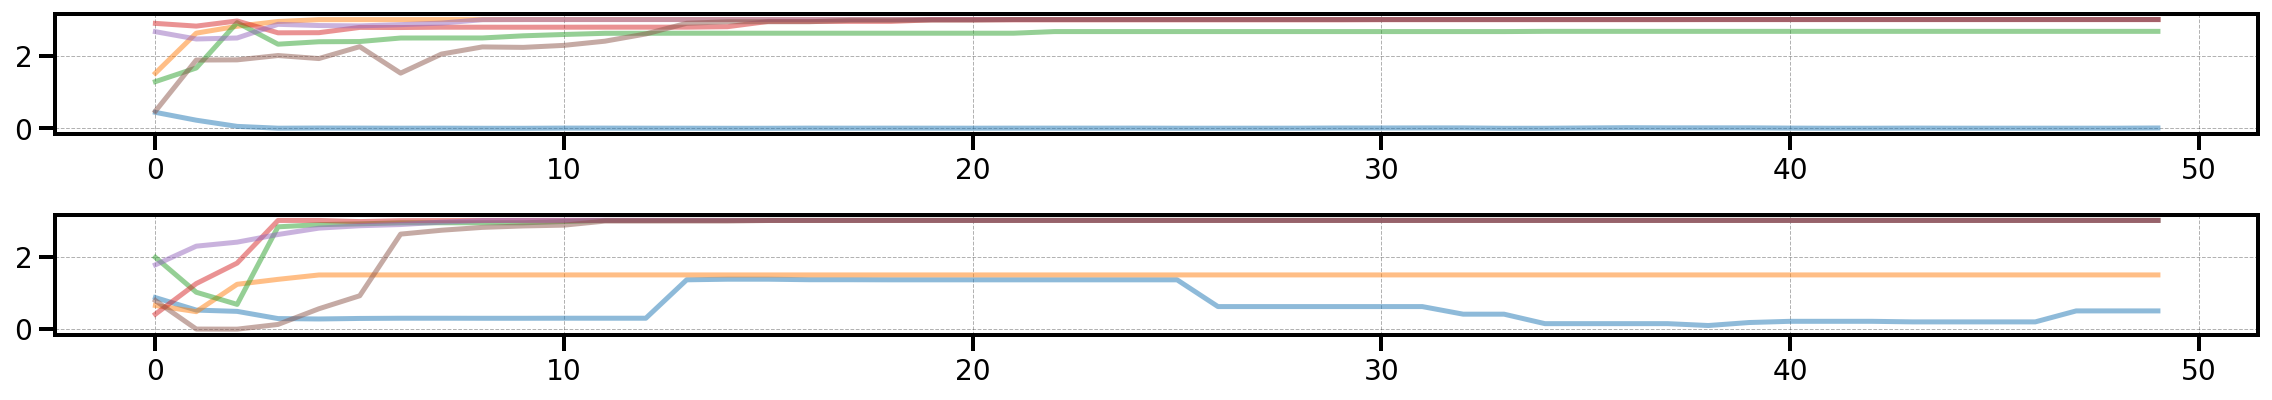

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


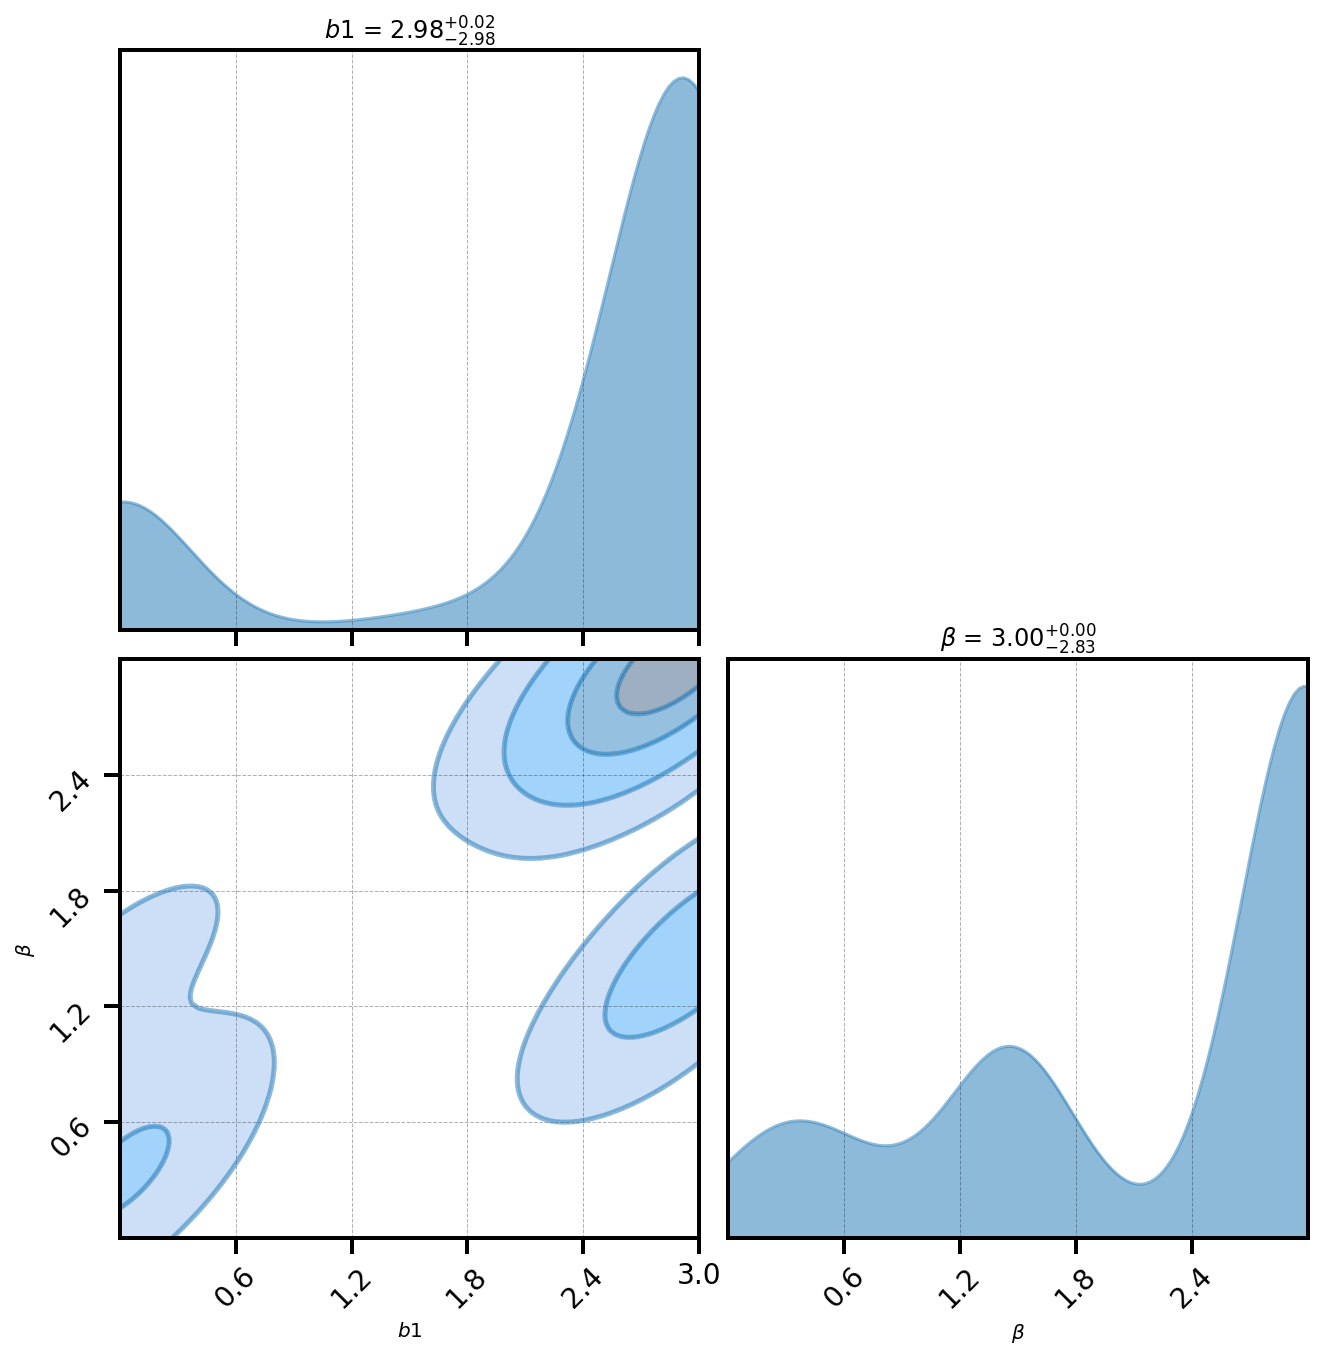

In [105]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
#     fig.axes[0].set_ylabel('b1')
#     fig.axes[1].set_ylabel('beta')
plt.tight_layout()
plt.show()

# plot marginal posterior distributions
fig, axes = zeus.cornerplot(chain, labels=[r'$b1$', r'$\beta$']);

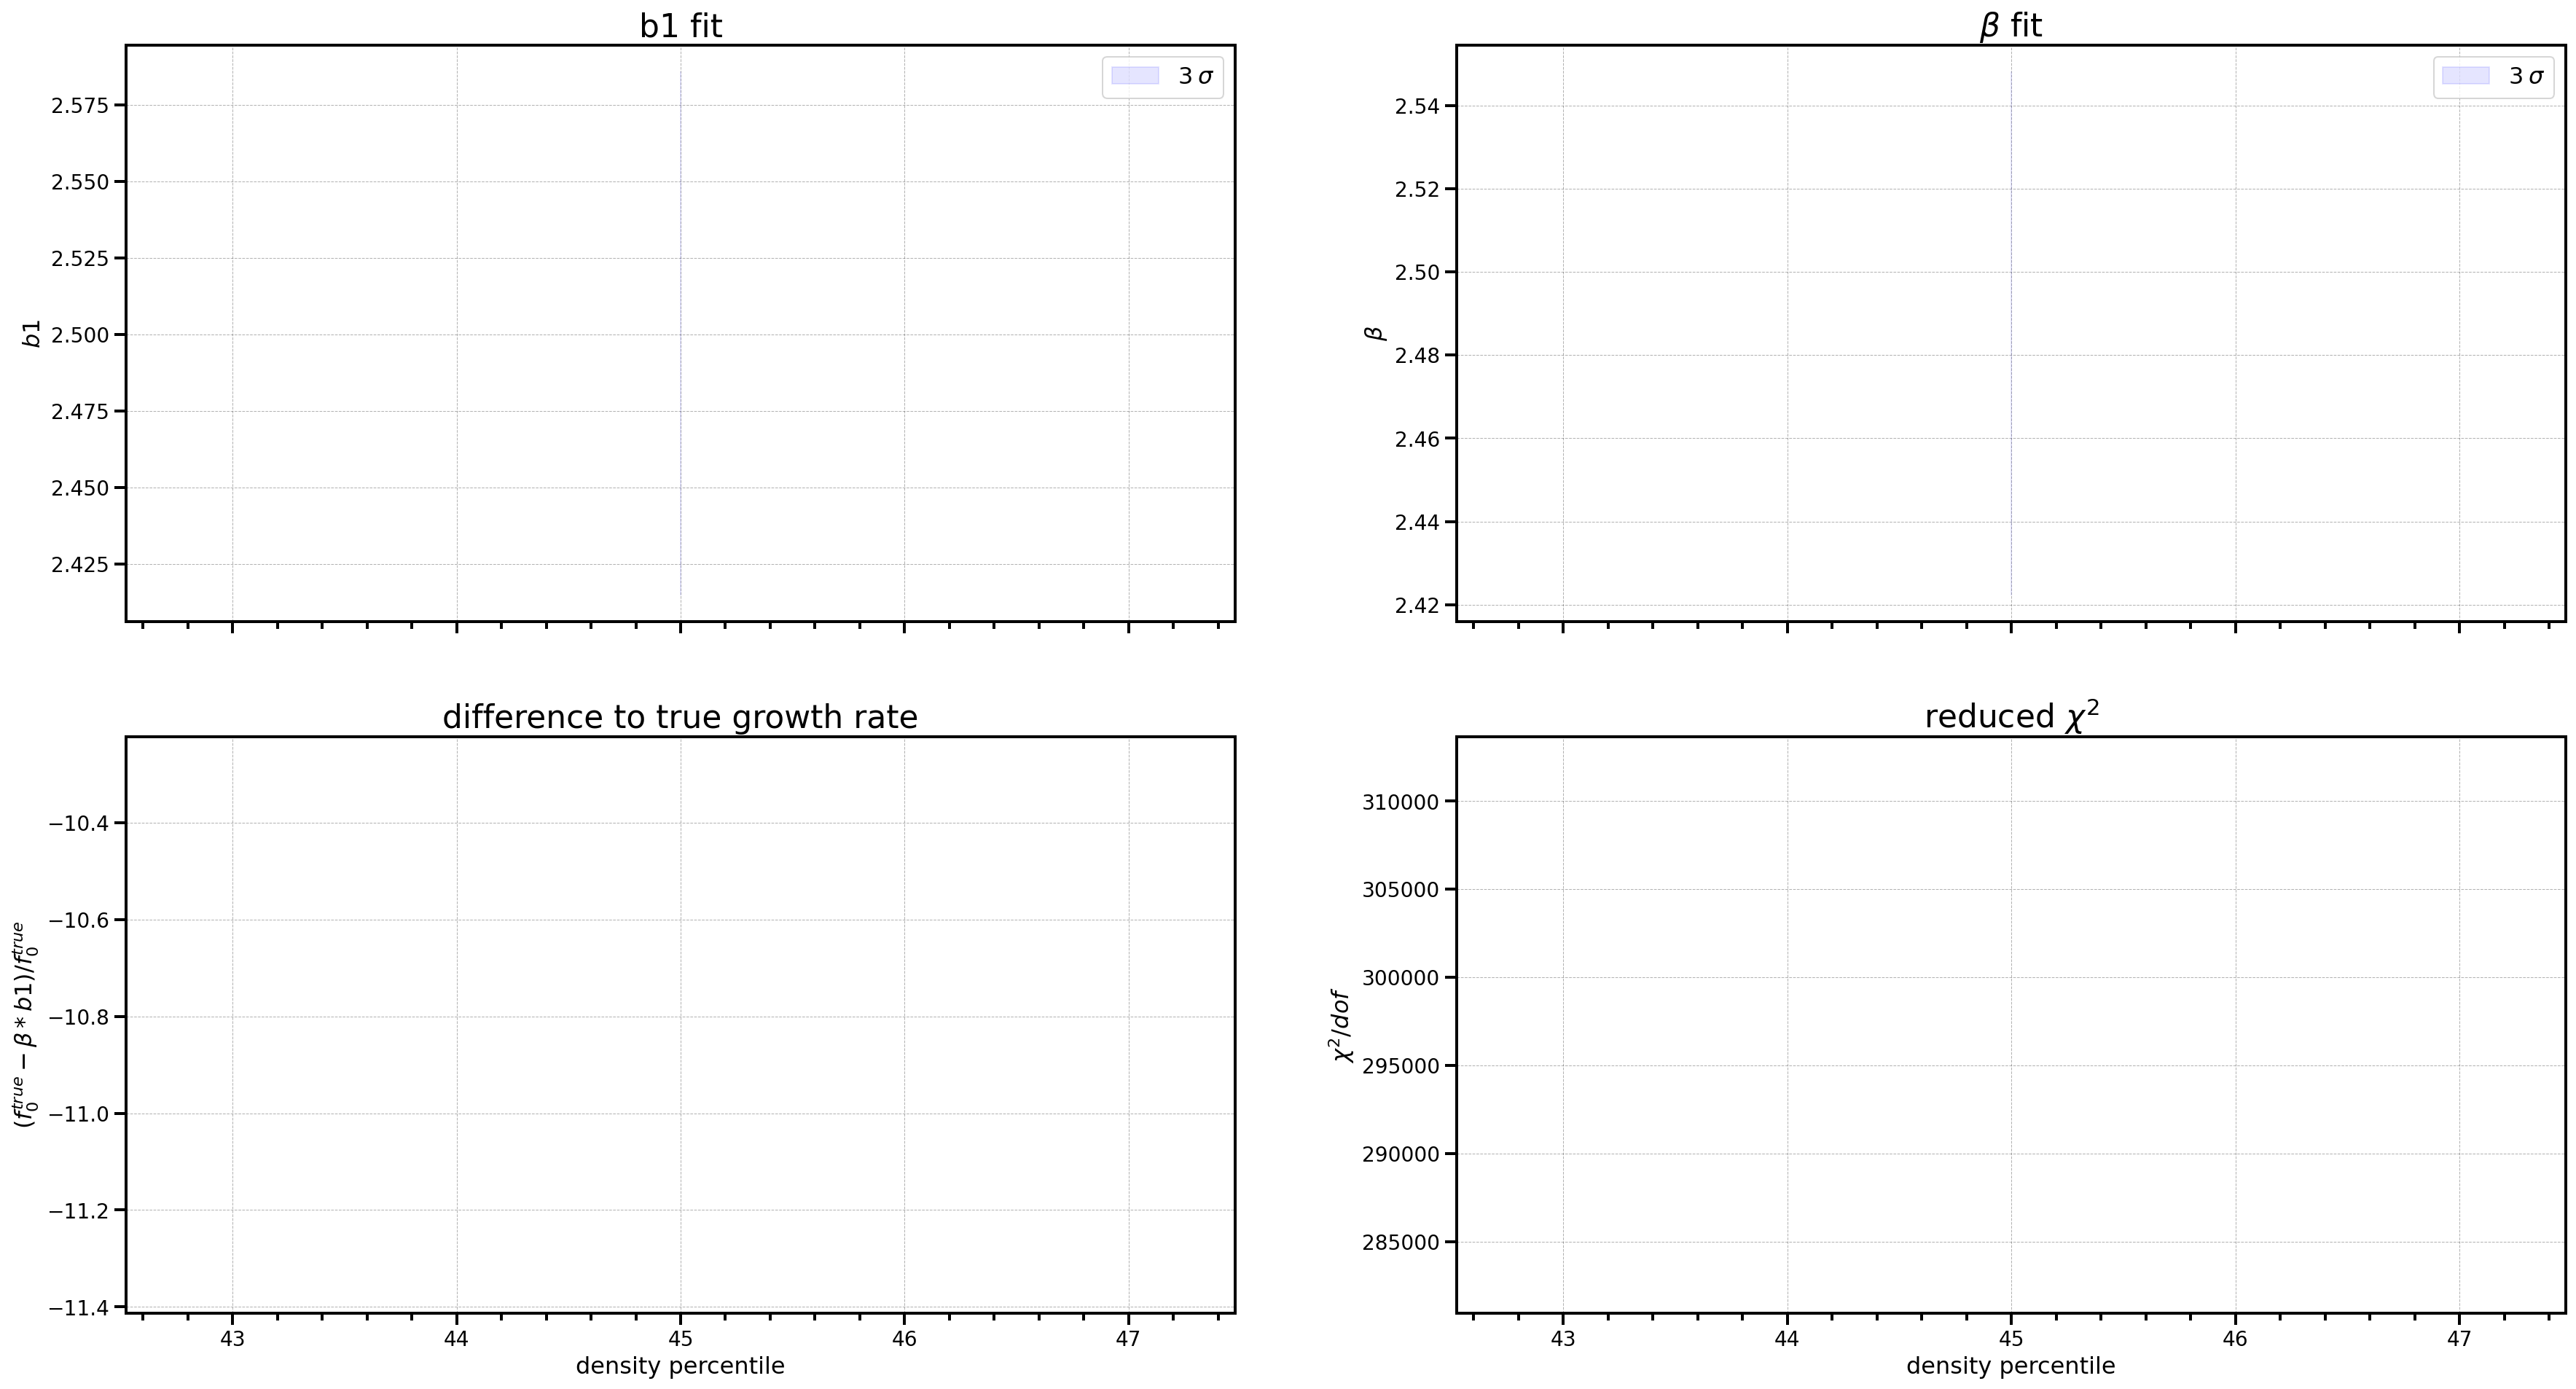

In [86]:
from matplotlib.ticker import AutoMinorLocator
fig, axs = plt.subplots(2, 2, figsize=(30,16), sharex=True)

mids = np.arange(5,105,10)[1:] # percentile mid points

axs[0][0].plot(mids, b1_fits[1:])
axs[0][0].fill_between(mids, b1_cred[:,0][1:], b1_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[0][0].set_title("b1 fit")
axs[0][0].set_ylabel(r"$b1$")
axs[0][0].legend()

axs[0][1].plot(mids, beta_fits[1:])
axs[0][1].fill_between(mids, beta_cred[:,0][1:], beta_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[0][1].set_title(r"$\beta$ fit")
axs[0][1].set_ylabel(r"$\beta$")
axs[0][1].legend()

f0_true = cosmo.scale_independent_growth_rate(redshift)
delta_f = (f0_true - (beta_fits*b1_fits)) / f0_true
#delta_f_cred = (b1_cred.T*beta_fits+b1_fits*beta_cred.T) / f0_true
axs[1][0].plot(mids, delta_f[1:])
#axs[1][0].fill_between(mids, delta_f_cred[0][1:], delta_f_cred[1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[1][0].set_title(r"difference to true growth rate")
axs[1][0].set_xlabel("density percentile")
axs[1][0].set_ylabel(r"$(f^{true}_0 - \beta*b1)/f^{true}_0$")
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())

axs[1][1].plot(mids, reduced_chi2[1:])
axs[1][1].set_title("reduced $\chi^2$")
axs[1][1].set_xlabel("density percentile")
axs[1][1].set_ylabel(r"$\chi^2 / dof$")
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())

plt.show()
#fig.savefig('plots/Fitting_b1_beta_densitybins_MCMC.pdf')

### Interpretation
The ball park of the fitted parameter is similar to the one found in the fitting via minimizing chi2. The issue with the first percentile remains: The quadrupole moment is entirely negative such that a negative beta is fitted which gives a good chi2 but a wrong f0.

The estimated f0 is better in this fit is better compared to the one from minimizing chi2. There still is a tendency to underestimate f0. 